# Homework 4

## FINM 36700 - 2023

### UChicago Financial Mathematics

**Professor**
* Mark Hendricks
* hendricks@uchicago.edu

**Students**

Kaleem Bukhari kbukhari@uchicago.edu

Aditya Murarka adityam@uchicago.edu

Raafay Uqaily raafay@uchicago.edu

Shrey Jain shreyjain@uchicago.edu

Tikhonov Sergei tikhonov@uchicago.edu


## Modules

In [2]:
import os
import pandas as pd
from scipy.stats import norm
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from arch import arch_model
from arch.univariate import GARCH
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

import matplotlib.pyplot as plt

## Helping functions

In [3]:
def performance_summary(return_data):

    summary_stats = return_data.mean().to_frame('Mean').apply(lambda x: x*12)
    summary_stats['Volatility'] = return_data.std().apply(lambda x: x*np.sqrt(12))
    summary_stats['Sharpe Ratio'] = summary_stats['Mean']/summary_stats['Volatility']
    
    summary_stats['Skewness'] = return_data.skew()
    summary_stats['Excess Kurtosis'] = return_data.kurtosis()
    summary_stats['VaR (0.05)'] = return_data.quantile(.05, axis = 0)
    summary_stats['CVaR (0.05)'] = return_data[return_data <= return_data.quantile(.05, axis = 0)].mean()
    summary_stats['Min'] = return_data.min()
    summary_stats['Max'] = return_data.max()
    
    wealth_index = 1000*(1+return_data).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdowns = (wealth_index - previous_peaks)/previous_peaks

    summary_stats['Max Drawdown'] = drawdowns.min()
    summary_stats['Peak'] = [previous_peaks[col][:drawdowns[col].idxmin()].idxmax() for col in previous_peaks.columns]
    summary_stats['Bottom'] = drawdowns.idxmin()
    
    recovery_date = []
    for col in wealth_index.columns:
        prev_max = previous_peaks[col][:drawdowns[col].idxmin()].max()
        recovery_wealth = pd.DataFrame([wealth_index[col][drawdowns[col].idxmin():]]).T
        recovery_date.append(recovery_wealth[recovery_wealth[col] >= prev_max].index.min())
    summary_stats['Recovery'] = recovery_date
    
    return summary_stats

In [4]:
def regression_based_performance(factor,fund_ret,rf,constant = True):

    if constant:
        X = sm.tools.add_constant(factor)
    else:
        X = factor
    y=fund_ret
    model = sm.OLS(y,X,missing='drop').fit()
    
    if constant:
        beta = model.params[1:]
        alpha = round(float(model.params['const']),6) * 12

        
    else:
        beta = model.params
    treynor_ratio = ((fund_ret - rf).mean() * 12)/beta[0]
    tracking_error = (model.resid.std() * np.sqrt(12))
    if constant:        
        information_ratio = model.params[0] * 12/tracking_error
    r_squared = model.rsquared
    if constant:
        return (beta,treynor_ratio,information_ratio,alpha,r_squared,tracking_error,model.resid)
    else:
        return (beta,treynor_ratio,r_squared,tracking_error,model.resid)

In [5]:
def computeTangencyPortfolio(df):


    mean = df.mean() * 12
    sigma = df.std() * np.sqrt(12)
    cov = df.cov() * 12
    cov_inv = np.linalg.inv(cov)
    
    w_t = pd.Series(cov_inv @ mean,index = mean.index, name = "TangencyPortfolio")
    w_t = w_t / sum(w_t)
    
    tangencyMean = w_t @ mean
    tangencyVol = np.sqrt(w_t.T @ cov @ w_t)
    tangencySharpe = tangencyMean / tangencyVol
    
    return w_t,tangencyMean,tangencyVol,tangencySharpe

## Data Reading

In [10]:
factors = pd.read_excel('factor_pricing_data.xlsx',sheet_name='descriptions',index_col='Unnamed: 0')
factors = pd.read_excel('factor_pricing_data.xlsx',sheet_name='factors (excess returns)',index_col='Date')
factors.head()

,MKT,SMB,HML,RMW,CMA,UMD
Date,,,,,,
1980-01-31,0.0551,0.0183,0.0175,-0.0170,0.0164,0.0755
1980-02-29,-0.0122,-0.0157,0.0061,0.0004,0.0268,0.0788
1980-03-31,-0.1290,-0.0693,-0.0101,0.0146,-0.0119,-0.0955
1980-04-30,0.0397,0.0105,0.0106,-0.0210,0.0029,-0.0043
1980-05-31,0.0526,0.0211,0.0038,0.0034,-0.0031,-0.0112


## 2.1 
### Analyze the factors, similar to how you analyzed the three Fama-French factors in Homework 4. You now have three additional factors, so let’s compare there univariate statistics.  
- ### mean
- ### volatility
- ### Sharpe


In [9]:
performance_summary(factors)[['Mean', 'Volatility', 'Sharpe Ratio']]

,Mean,Volatility,Sharpe Ratio
MKT,0.084562,0.157284,0.537641
SMB,0.011206,0.100525,0.111476
HML,0.025324,0.110162,0.229880
RMW,0.046525,0.083404,0.557824
CMA,0.032492,0.073379,0.442794
UMD,0.060925,0.155507,0.391780


## 2.2
### Based on the factor statistics above, answer the following. <br><br> (a) Does each factor have a positive risk premium (positive expected excess return)?

**Answer**: Yes, all the factors have positive risk premium in the whole sample. 

### (b) How have the factors performed since the time of the case, (2015-present)?

In [15]:
performance_summary(factors.loc['2015':])[['Mean', 'Volatility', 'Sharpe Ratio']]

,Mean,Volatility,Sharpe Ratio
MKT,0.111705,0.162705,0.686549
SMB,-0.008377,0.098268,-0.085244
HML,-0.025817,0.135825,-0.190080
RMW,0.048594,0.073131,0.664483
CMA,0.001794,0.086965,0.020631
UMD,0.006501,0.144006,0.045144


**Answer**: Since the time of the case, MKT is still the factor with the highest risk premium. The second and third factors are UMD and RMW, respectively. While CMA is relatively negligible, SMB and HML have shown negative excess return 

## 2.3
### Report the correlation matrix across the six factors.

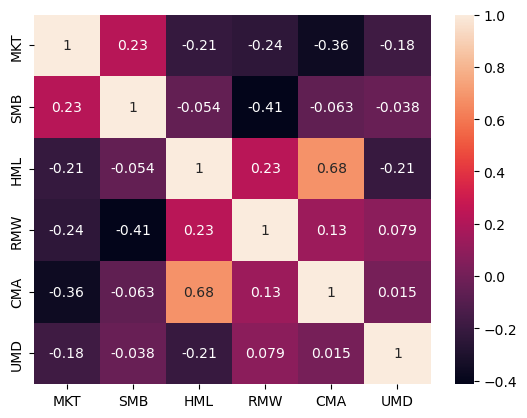

In [19]:
corr = factors.corr()
sns.heatmap(corr, annot = True);

### (a) Does the construction method succeed in keeping correlations small?

**Answer**: In general, most correlations are relatively small despite a few factors (for example, HML and CMA, SMB and RMW, MKT and CMA). So the construction method indeed succeeded in keeping correlations small.

### (b) Fama and French say that HML is somewhat redundant in their 5-factor model. Does this seem to be the case?

**Answer**: There is a high correlation (0.68) between HML and CMA. That is why we can conclude that in 5-factor model, HML can be seen as a redundant factor

## 2.4
### Report the tangency weights for a portfolio of these 6 factors.

In [20]:
tangencyWt,tangencyMean,tangencyVol, tangencySharpe = computeTangencyPortfolio(factors)
tangencyWt.to_frame("Tangency Weights").sort_values('Tangency Weights',ascending = False).T

,CMA,RMW,MKT,UMD,SMB,HML
Tangency Weights,0.369283,0.307353,0.203875,0.093818,0.087446,-0.061776


### (a) Which factors seem most important? And Least?

**Answer**: 

According to tangency portfolio:

The most important factor is CMA, while the least important factor is HML.

### (b) Are the factors with low mean returns still useful?

In [23]:
pd.concat([performance_summary(factors)['Mean'], tangencyWt], axis = 1).sort_values('Mean', ascending = False)

,Mean,TangencyPortfolio
MKT,0.084562,0.203875
UMD,0.060925,0.093818
RMW,0.046525,0.307353
CMA,0.032492,0.369283
HML,0.025324,-0.061776
SMB,0.011206,0.087446


**Answer**: As the analysis of tangency weights shows, factors with relatively low mean returns (CMA, RMW) have the largest weights. On the other hand, HML and SMB with the lowest mean returns have the smallest weights.

### (c) Re-do the tangency portfolio, but this time only include MKT, SMB, HML, and UMD. Which factors get high/low tangency weights now?

In [26]:
tangencyWt,tangencyMean,tangencyVol, tangencySharpe = computeTangencyPortfolio(factors[['MKT', 'SMB', 'HML', 'UMD']])
tangencyWt.to_frame("Tangency Weights").sort_values('Tangency Weights',ascending = False).T

,MKT,HML,UMD,SMB
Tangency Weights,0.35644,0.348903,0.300861,-0.006204


**Answer**: for now, HML has the second largest weight even though its returns are one of the lowest among considered factors.

### What do you conclude about the importance or unimportance of these styles?

1. According to correlation-based analysis, we can see that HML looks redundant because of high correlation with CMA.

2. According to tangency-based analysis, we can confirm that HML is redundant because it has the lowest weight among the factors

3. All other factors fit good (low correlations with each other, more or less high mean returns). 

# 3 Testing Modern LPMs

## 1. Test the AQR 4-Factor Model using the time-series test. (We are not doing the cross-sectional regression tests.)

In [28]:
portfolios = pd.read_excel('factor_pricing_data.xlsx', sheet_name='portfolios (excess returns)', index_col='Date')

In [38]:
def time_series_test(seriesY, seriesX):
    

    y = seriesY
    X = sm.add_constant(seriesX)
    model = sm.OLS(y, X).fit()
    
    rsq = model.rsquared
    beta = pd.DataFrame(index = [seriesY.name])
    
    for i,x in enumerate(seriesX):
         beta[x] = model.params[i + 1]
    
    betaCols = [i + 'Beta' for i in seriesX]
    beta = beta.rename(columns = dict(zip(beta.columns, betaCols)))
    mean = seriesY.mean() * 12
    sharpe = mean / (seriesY.std() * (12 ** 0.5))  
    treynor = mean / beta[beta.columns[0]]
    alpha = model.params[0] * 12
    information = alpha/(model.resid.std() * np.sqrt(12))
    
    RegressionStats = pd.DataFrame({'Mean Return':mean,
                                    'Sharpe Ratio':sharpe,
                                    'R Squared':rsq,
                                    'Alpha':alpha, 
                                    'Information Ratio':information, 
                                    'Treynor':treynor}, index= [seriesY.name])
    
    return pd.concat([RegressionStats,beta], axis = 1)

In [54]:
aqr = factors[['MKT', 'HML', 'RMW', 'UMD']]

frames = []

for col in portfolios:
    
    p = time_series_test(portfolios[col], aqr)
    frames.append(p) 
    
AQRRegression = pd.concat(frames)
AQRRegression

,Mean Return,Sharpe Ratio,R Squared,Alpha,Information Ratio,Treynor,MKTBeta,HMLBeta,RMWBeta,UMDBeta
Agric,0.089693,0.412541,0.341333,0.009491,0.053788,0.107052,0.837838,0.178699,-0.006405,0.084119
Food,0.099669,0.660014,0.471088,0.011434,0.104111,0.146377,0.680903,0.169841,0.507359,0.045146
Soda,0.108840,0.490980,0.307178,0.019555,0.105981,0.138704,0.784688,0.206106,0.494736,-0.087111
Beer,0.119426,0.700661,0.426698,0.024178,0.187339,0.165106,0.723330,0.025183,0.600586,0.090319
Smoke,0.132925,0.592263,0.272555,0.035317,0.184497,0.180305,0.737220,0.249344,0.657434,-0.026824
Toys,0.062946,0.252209,0.510315,-0.032189,-0.184306,0.056362,1.116824,-0.035336,0.230797,-0.150169
Fun,0.118245,0.446060,0.617319,0.031788,0.193848,0.094682,1.248868,0.000177,-0.109524,-0.230768
Books,0.074122,0.357971,0.689702,-0.030329,-0.262943,0.066563,1.113566,0.265474,0.177919,-0.077390
Hshld,0.081545,0.529226,0.560258,-0.005510,-0.053928,0.108322,0.752802,0.000889,0.485108,0.013206
Clths,0.098083,0.437351,0.631763,-0.011724,-0.086150,0.087683,1.118614,0.049475,0.564987,-0.202276


In [55]:
AQRRegression.mean()

Mean Return          0.091234
Sharpe Ratio         0.422665
R Squared            0.577081
Alpha               -0.003944
Information Ratio   -0.023078
Treynor              0.091504
MKTBeta              1.042857
HMLBeta              0.134882
RMWBeta              0.156546
UMDBeta             -0.060840
dtype: float64

### Calculate the mean-absolute-error of the estimated alphas, (one for each security, ˜ri.)

In [41]:
AQR_MAE = round(abs(AQRRegression['Alpha']).mean(), 6)
print(f'Mean Absolute Error for AQR factors: {AQR_MAE}')

Mean Absolute Error for AQR factors: 0.022995


### If the pricing model worked, should these alpha estimates be large or small? Why? Based on your MAE stat, does this seem to support the pricing model or not?

**Answer**: Theoretically, alphas must be zero since the factors must be sufficient to explain most of the variation in excess portfolio return. However, since we use statistical approach, due to the noise in observations, alphas should be small. Here we see that mean absolue error for AQR factors is relatively small. That's why we can conclude, based on MAE, that the AQR pricing model is good.

## 3.2
### Test the CAPM, FF 3-Factor Model and the the FF 5-Factor Model. Report the MAE statistic for each of these models and compare it with the AQR Model MAE. Which model fits best?

In [44]:
mkt = factors[['MKT']]

frames = []

for col in portfolios:
    
    p = time_series_test(portfolios[col], mkt)
    frames.append(p) 
    
mktRegression = pd.concat(frames)
mkt_MAE = round(abs(mktRegression['Alpha']).mean(), 6)
print(f'Mean Absolute Error CAPM: {mkt_MAE}')

Mean Absolute Error CAPM: 0.020608


In [52]:
mktRegression.mean(axis=0)

Mean Return          0.091234
Sharpe Ratio         0.422665
R Squared            0.528087
Alpha                0.005495
Information Ratio    0.045943
Treynor              0.096156
MKTBeta              1.013924
dtype: float64

In [45]:
ff3 = factors[['MKT', 'SMB', 'HML']]

frames = []

for col in portfolios:
    
    p = time_series_test(portfolios[col], ff3)
    frames.append(p) 
    
ff3Regression = pd.concat(frames)
ff3_MAE = round(abs(ff3Regression['Alpha']).mean(), 6)
print(f'Mean Absolute Error CAPM: {ff3_MAE}')

Mean Absolute Error CAPM: 0.0242


In [50]:
ff3Regression.mean(axis=0)

Mean Return          0.091234
Sharpe Ratio         0.422665
R Squared            0.572516
Alpha               -0.001156
Information Ratio    0.000099
Treynor              0.094123
MKTBeta              1.016358
SMBBeta              0.167483
HMLBeta              0.180372
dtype: float64

In [58]:
ff5 = factors[['MKT', 'SMB', 'HML', 'RMW', 'CMA']]

frames = []

for col in portfolios:
    
    p = time_series_test(portfolios[col], ff5)
    frames.append(p) 
    
ff5Regression = pd.concat(frames)
ff5_MAE = round(abs(ff5Regression['Alpha']).mean(), 6)
print(f'Mean Absolute Error CAPM: {ff5_MAE}')

Mean Absolute Error CAPM: 0.031272


In [59]:
ff5Regression.mean(axis=0)

Mean Return          0.091234
Sharpe Ratio         0.422665
R Squared            0.597519
Alpha               -0.018618
Information Ratio   -0.127044
Treynor              0.090187
MKTBeta              1.044790
SMBBeta              0.251245
HMLBeta              0.095741
RMWBeta              0.272760
CMABeta              0.109949
dtype: float64

**Answer**: according to MAE error, CAPM fits the best among FF 3-Factor model, FF 5-Factor model, and AQR model.

## 3.3
### Does any particular factor seem especially important or unimportant for pricing? Do you think Fama and French should use the Momentum Factor?

**Answer**: Market factor is indeed the most important factor in all factor models we tested. Considering other factors, we can see that the weights of different factors change from one factor model to another, that's why we cannot be sure that those factors are unimportant for pricing. 

**Answer**: Fama is the creator of the efficient market hypothesis. The existance of momentum factor would indeed contradict to his theory, that was probably a reason why he didn't include this factor to his factor model. However, according to the calculations above, we can see that momentum is an important factor, because AQR performance is higher than each FF 3 Factor model and FF 5 Factor model (even though the weight of UMD is the lowest).

## 3.4
### This does not matter for pricing, but report the average (across n estimations) of the time-series regression r-squared statistics. Do this for each of the three models you tested. Do these models lead to high time-series r-squared stats? That is, would these factors be good in a Linear Factor Decomposition of the assets?


In [64]:
MKT_RSq = mktRegression['R Squared'].mean()
AQR_RSq = AQRRegression['R Squared'].mean()
FF3_RSq = ff3Regression['R Squared'].mean()
FF5_RSq = ff5Regression['R Squared'].mean()

Average_R_Squared = pd.Series({'MKT': MKT_RSq, 'AQR':AQR_RSq,'FF3':FF3_RSq,'FF5':FF5_RSq})
Average_R_Squared.to_frame("Average R Squared").T

,MKT,AQR,FF3,FF5
Average R Squared,0.528087,0.577081,0.578308,0.597519


**Answer**: R2 of all factors are in range from 0.52 to 0.59. This is a relatively poor performance.

## 3.5
### We tested three models using the time-series tests (focusing on the time-series alphas.) Re-test these models, but this time use the cross-sectional test.

### (a) Report the time-series premia of the factors (just their sample averages,) and compare to the cross-sectionally estimated premia of the factors. Do they differ substantially?

In [89]:
time_series_premia = (factors.mean()*12).to_frame('Time Series Premia')
time_series_premia.index = [x+"Beta" for x in time_series_premia.index]
time_series_premia.T

,MKTBeta,SMBBeta,HMLBeta,RMWBeta,CMABeta,UMDBeta
Time Series Premia,0.084562,0.011206,0.025324,0.046525,0.032492,0.060925


In [90]:
y = AQRRegression['Mean Return']
x = AQRRegression[['MKTBeta','HMLBeta','RMWBeta','UMDBeta']]
AQRRegressionCS = sm.OLS(y,x,missing='drop').fit()
AQR_CS_MAE = AQRRegressionCS.resid.abs().mean()
AQR_CS_premia = AQRRegressionCS.params.to_frame("AQR CS Premia")
AQR_CS_premia.T

,MKTBeta,HMLBeta,RMWBeta,UMDBeta
AQR CS Premia,0.087644,-0.039757,0.044399,0.053375


In [91]:
y = mktRegression['Mean Return']
x = mktRegression[['MKTBeta']]
AQRRegressionCS = sm.OLS(y, x, missing='drop').fit()
CAPM_CS_MAE = AQRRegressionCS.resid.abs().mean()
CAPM_CS_premia = AQRRegressionCS.params.to_frame("CAPM CS Premia")
CAPM_CS_premia.T

,MKTBeta
CAPM CS Premia,0.085667


In [92]:
y = ff3Regression['Mean Return']
x = ff3Regression[['MKTBeta','SMBBeta','HMLBeta']]
FF3RegressionCS = sm.OLS(y, x, missing='drop').fit()
FF3_CS_MAE = FF3RegressionCS.resid.abs().mean()
FF3_CS_Premia = FF3RegressionCS.params.to_frame("FF3 CS Premia")
FF3_CS_Premia.T

,MKTBeta,SMBBeta,HMLBeta
FF3 CS Premia,0.10217,-0.06256,-0.015919


In [93]:
y = ff5Regression['Mean Return']
x = ff5Regression[['MKTBeta','SMBBeta','HMLBeta','RMWBeta','CMABeta']]
FF5RegressionCS = sm.OLS(y, x, missing='drop').fit()
FF5_CS_MAE = FF5RegressionCS.resid.abs().mean()
FF5_CS_Premia = FF5RegressionCS.params.to_frame("FF5 CS Premia")
FF5_CS_Premia.T

,MKTBeta,SMBBeta,HMLBeta,RMWBeta,CMABeta
FF5 CS Premia,0.095697,-0.057674,-0.033504,0.035899,-0.015156


In [95]:
pd.concat([time_series_premia, CAPM_CS_premia, FF3_CS_Premia, AQR_CS_premia, FF5_CS_Premia], axis = 1).fillna('')

,Time Series Premia,CAPM CS Premia,FF3 CS Premia,AQR CS Premia,FF5 CS Premia
MKTBeta,0.084562,0.085667,0.10217,0.087644,0.095697
SMBBeta,0.011206,,-0.06256,,-0.057674
HMLBeta,0.025324,,-0.015919,-0.039757,-0.033504
RMWBeta,0.046525,,,0.044399,0.035899
CMABeta,0.032492,,,,-0.015156
UMDBeta,0.060925,,,0.053375,


**Answer**: cross-sectional estimated premia and time series premia of the factors don't differ substantially in most factor models. However, there are a few exceptions: SMB in FF3 and FF5; HML in FF3, AQR, and FF5; CMA in FF5.

As an additional clarification, for cross-sectional regression one can check R2.

### (b) Report the MAE of the cross-sectional regression residuals for each of the four models, (the υi.) How do they compare to the MAE of the time-series alphas?

In [103]:
MAE_TS = pd.Series([AQR_MAE, mkt_MAE, ff3_MAE, ff5_MAE], index = ["AQR", "MKT", "FF-3", "FF-5"])
MAE_CS = pd.Series([AQR_CS_MAE, CAPM_CS_MAE, FF3_CS_MAE, FF5_CS_MAE], index = MAE_TS.index)
MAE = pd.concat([MAE_TS,MAE_CS], axis = 1)
MAE.columns = ['Time Series MAE', 'Cross Section MAE']
MAE

,Time Series MAE,Cross Section MAE
AQR,0.020608,0.016395
MKT,0.020608,0.020655
FF-3,0.022568,0.014554
FF-5,0.031272,0.012982


**Answer**: The MAE of cross-sectional regression is in general lower than the MAE of alphas in time-series regression. 